In [ ]:
# default_exp FLIR_camera_calibration_utils
# default_cls_lvl 3

# FLIR Camera Calibration
> Utilities for calibrating a cameras 

These routines are designed to be run on a rov computer connected via ethernet to a `ssh` client.
The idea is that the rov can be operated in an underwater environment in proximity to a 
calibration target and images captured. The routines are intended to be controlled from a PC via `ssh` 
with the PC also running `flir-client.py` viewer.

### Setup
To run these examples install Jupyter Notebook  
`pip install notebook`
Note for some reasen I had to change the second to last line

``` "nbformat_minor": 1 ```

to

``` "nbformat_minor": 4 ```


In [ ]:
from nbdev.showdoc import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2

### Capture Utility

In [ ]:
# export

import imutils
import cv2
from imutils.video import FPS
import zmq
import numpy as np
import time

class Capture:
    def __init__(self, name='FrontLeft', url='localhost'):
        self.PORT = 5555
        self.width = 1000
        self.height = 750
        self.name = name
        self.url = url
        self.socket_sub = None
        self.context = None


    def _recv_array(self, socket:zmq.Context.socket, flags=0, copy=True, track=False):
        """recv a numpy array"""
        md = socket.recv_json(flags=flags)
        msg = socket.recv(flags=flags, copy=copy, track=track)
        buf = memoryview(msg)
        A = np.frombuffer(buf, dtype=md['dtype'])
        # return (A.reshape(md['shape']), md)
        return (A, md)

    def _recv_frame(self, socket):
        """ Receive and process an image from camera"""
        try:
            #  Get the reply.
            topic = socket.recv_string()
            rec_frame, md = self._recv_array(socket)
            rec_frame = cv2.imdecode(rec_frame, cv2.IMREAD_GRAYSCALE)
            rec_frame = cv2.cvtColor(rec_frame, cv2.COLOR_BAYER_BG2BGR)
            rec_frame = rec_frame.reshape((3000, 4000, 3))
            # rec_frame = imutils.resize(rec_frame, width=width, height=height)
            # cv2.putText(rec_frame, f'Received frame {md}',
            #             (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        except Exception as e:
            rec_frame = np.ones((self.width, self.height))
            topic = 'cam1'
            md = None
            # cv2.putText(rec_frame, f'error:  {e}',
            #             (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
            print (f"error: message timeout {e}")
            time.sleep(1)
        return topic, rec_frame, md

    def _poll_server(self):
        context = zmq.Context()
        socket = context.socket(zmq.REQ)
        socket.connect(f"tcp://{self.url}:{self.PORT + 1}")
        socket.setsockopt(zmq.LINGER, 0)
        poller = zmq.Poller()
        poller.register(socket, flags=zmq.POLLIN)

        socket.send_string(f"keep_alive {self.name}")
        result = dict(poller.poll(1000))
        poller.unregister(socket)

    def open_client(self, name='FrontLeft', url='localhost'):
        """ Received frames from a single camera. Must have the server running"""

        self.context = zmq.Context()

        # subscribe socket
        print( "Connecting to server...")
        self.socket_sub = self.context.socket(zmq.SUB)
        self.socket_sub.connect( f"tcp://{url}:{self.PORT}")
        self.socket_sub.setsockopt_string(zmq.SUBSCRIBE, name)


    def close_client(self):
        self.socket_sub.close()

        self.context.term()
        cv2.destroyAllWindows()

        print('Finished')

#     def get_image(self):
#         self._poll_server()

#         try:
#             topic, rec_frame, md = self._recv_frame(self.socket_sub)
# #             rec_frame = imutils.resize(rec_frame, width=2400, height=1800)

#         except KeyboardInterrupt:
#             pass

#         return topic, rec_frame, md

    def fetch_image(self):
        self.open_client()
        self._poll_server()
        topic, rec_frame, md = self._recv_frame(self.socket_sub)
        self.close_client()
        return topic, rec_frame, md

### Collect images
Utility to collect images

Button(description='Capture Image', style=ButtonStyle())

Button(description='Save Image', style=ButtonStyle())

Connecting to server...
Finished


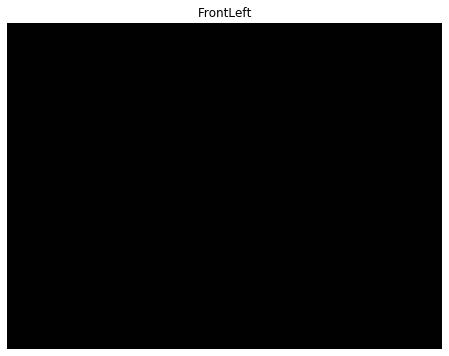

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

btnCapture = widgets.Button(description="Capture Image")
btnSave = widgets.Button(description="Save Image")
display(btnCapture)
display(btnSave)

cap = Capture()

rec_frame = None
topic = None
    
def cap_button_clicked(b):
    global rec_frame, topic
    clear_output()
    display(btnCapture)
    display(btnSave)
    topic, rec_frame, md = cap.fetch_image()
    show_img(rec_frame, figsize=(8, 6), title=topic)
    
def save_button_clicked(b):
    global rec_frame, topic
    print(f'Saving {topic}.jpg')
    cv2.imwrite(f'{topic}.jpg', rec_frame) 

        
btnCapture.on_click(cap_button_clicked)
btnSave.on_click(save_button_clicked)

    

In [ ]:
show_img(rec_frame, ax=axes, title=topic)

In [ ]:
def show_img(im, figsize=None, ax=None, alpha=None, label=None, mode=None, axis_on=False, title=None, cmap=None, vmin=0, vmax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap=cmap, vmin=vmin, vmax=vmax)
    if not axis_on:
        ax.set_axis_off()
    if label: ax.legend()
    if title: ax.set_title(title)
    return ax

### Camera Calibration.
Measure  distortions in camera, intrinsic and extrinsic parameters of camera etc.  
We will learn to find these parameters, undistort images etc.  
Basics  
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html#calibration  


Left and right camera samples are in the local `nbs\sample_data\` directory. 

In [ ]:
import cv2
cv2.samples.addSamplesDataSearchPath('sample_data')
src2 = cv2.imread(cv2.samples.findFile('left01.jpg'))
imshow(src2)

### Find chess board image corner points points
To find pattern in chess board, we use the function, cv2.findChessboardCorners()  
Pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid etc. In this example, we use 7x6 grid. 
Once we find the corners, we can increase their accuracy using cv2.cornerSubPix().  

In [ ]:
import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
images = glob.glob('sample_data/left*.jpg')

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)
         
    show_img(img, ax=axes.flat[i])

cv2.destroyAllWindows()
plt.tight_layout()

### Calibration
The function cv2.calibrateCamera() returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [ ]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
len(rvecs)

### Undistortion

In [ ]:
img = cv2.imread('sample_data/left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs,(w,h),1,(w,h))

dst = cv2.undistort(img, cameraMatrix, distCoeffs, None, newcameramtx)

# crop the image
# x,y,w,h = roi
# dst = dst[y:y+h, x:x+w]
# cv2.imwrite('calibresult.png',dst)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img(img, ax=ax1, title='origonal')
show_img(dst, ax=ax2, title='undistorted')
plt.tight_layout()

print(cameraMatrix.shape , distCoeffs.shape, newcameramtx.shape)

### Using remapping
First find a mapping function from distorted image to undistorted image. Then use the remap function.
Then use the undistorted pixels x,y to select the mapping pixel from the distorted image

In [ ]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(cameraMatrix, distCoeffs, None,newcameramtx, (w,h), 5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
# x,y,w,h = roi
# dst = dst[y:y+h, x:x+w]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img(img, ax=ax1, title='origonal')
show_img(dst, ax=ax2, title='nndistorted')
plt.tight_layout()

In [ ]:
print(mapx.shape , mapy.shape)

### Re-projection Error
Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible.

In [ ]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print ("total error: ", mean_error/len(objpoints))
print('len(objpoints): ', len(objpoints))



### Save in camera yaml file

In [ ]:
import yaml
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

# import pyaml
import pickle
from pathlib import Path

yaml_dir= Path.cwd()/'common'
serial = '19444715'

yaml_path = f'{yaml_dir/serial}.yaml'

with open(yaml_path, 'rb') as file:
    yaml_dict = yaml.load(file, Loader=Loader)
    print(yaml.dump(yaml_dict))

obj = {'cameraMatrix': cameraMatrix.tolist() , 'distCoeffs': distCoeffs.tolist(), 'newcameramtx': newcameramtx.tolist()}
# 
# with open('common/calibration.pkl','wb') as f: 
#     pickle.dump(obj, f)   
# 
# with open('common/calibration.pkl','rb') as f: 
#     objin = pickle.load(f)

# calibration = pickle.dumps(obj)
yaml_dict['calibration'] = obj

with open(yaml_path, 'w') as file:
    yaml.dump(yaml_dict, file)
    
print("fin")    

In [ ]:
with open(yaml_path, 'rb') as file:
    yaml_dict = yaml.load(file, Loader=Loader)
    print(yaml.dump(yaml_dict))

In [ ]:
cal = yaml_dict['calibration']
cameraMatrix = cal['cameraMatrix']
distCoeffs = cal['distCoeffs']
newcameramtx = cal['newcameramtx']
print(newcameramtx)


##  Misc

###  Create a depth map from stereo images

In [ ]:
from matplotlib import pyplot as plt
imgL = cv2.imread('sample_data/tsukuba_l.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('sample_data/tsukuba_r.png', cv2.IMREAD_GRAYSCALE)
stereo = cv2.StereooBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
show_img(imgL, ax=ax1, title='origonal')
show_img(disparity, ax=ax2, title='disparity')
plt.tight_layout() 